# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
a = ""
a

''

In [3]:
class preprocess:
    
    paths = {}

    def get_files(folder_path):
        paths = {}
        for path, subdirs, files in os.walk(folder_path):
            for name in files:
                if name.endswith("csv"):
                    key = name.split("_")[0]

                    if paths.get(key) is None:
                        paths[key] = {}

                    if name.endswith("_x.csv"):
                        x = os.path.join(path, name)
                        paths[key]['x'] = x
                    elif name.endswith("_y.csv"):
                        y = os.path.join(path, name)
                        paths[key]['y'] = y
        preprocess.paths = paths
        return paths

    def get_data(paths):
        for key, value in paths.items():
            x = pd.read_csv(value['x'])
            y = pd.read_csv(value['y'])
            #print(x.shape)
            #print(x.values.shape)
            #print(y.sum())
            yield key, x.values, y.values
        
        
    
    
train_paths = preprocess.get_files("dataset/Kyoto2016/2014/01")
test_paths = preprocess.get_files("dataset/Kyoto2016/2015/01")

print(train_paths)
print("----------------------------------------------------------------------------------------")
test_paths = test_paths.popitem()
test_paths = {test_paths[0]: test_paths[1]}
print(test_paths)


{'20140122': {'y': 'dataset/Kyoto2016/2014/01/20140122_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140122_x.csv'}}
----------------------------------------------------------------------------------------
{'20150128': {'y': 'dataset/Kyoto2016/2015/01/20150128_y.csv', 'x': 'dataset/Kyoto2016/2015/01/20150128_x.csv'}}


In [4]:
x_data = pd.read_csv('dataset/Kyoto2016/2014/01/20140122_x.csv')
y_data = pd.read_csv('dataset/Kyoto2016/2014/01/20140122_y.csv')

In [5]:
x_data_test = pd.read_csv('dataset/Kyoto2016/2015/01/20150128_x.csv')
y_data_test = pd.read_csv('dataset/Kyoto2016/2015/01/20150128_y.csv')

In [6]:
x1 = x_data[y_data.is_Attack== 1].sample(500)
x2 = x_data[y_data.is_Normal== 1]

x_data_temp = pd.concat((x1, x2))
x_data_temp = x_data_temp.sort_index()

In [7]:
y_data_temp = y_data.iloc[x_data_temp.index.values,:]
y_data_temp = y_data_temp.sort_index()

In [8]:
y_data_temp.sum()

is_Attack     500
is_Normal    1282
dtype: int64

In [9]:
y_data_test.sum()

is_Attack    237077
is_Normal      7418
dtype: int64

In [10]:
import tensorflow as tf


In [11]:
class network(object):
    
    input_dim = 42
    classes = 2
    hidden_encoder_dim = 42
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))
            #loss = tf.losses.mean_squared_error(labels = self.y_, predictions = self.y)
            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")
            
        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [12]:
import collections
import time
from sklearn import model_selection as ms
from sklearn import metrics as me

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'time_taken'])

    predictions = {}
    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_data_temp.values, 
                                                                                  y_data_temp.values, 
                                                                                  test_size=0.1)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            def train_batch():
                                nonlocal train_loss
                                _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:0.5, net.lr:lr})

                            train_batch()
                            #summary_writer_train.add_summary(summary_str, epoch)
                            #print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                                print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                                net.saver.restore(sess, 
                                                  tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                             .format(epochs,h,f)))
                                train_batch()


                        valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_valid.add_summary(summary_str, epoch)
                    
                        print("Key {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(key, train_loss, valid_accuracy))
                    

                    for key, x_test, y_test in preprocess.get_data(test_paths):
                        accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                               net.pred, 
                                                                               net.actual, net.y], 
                                                                              feed_dict={net.x: x_test, 
                                                                                         net.y_: y_test, 
                                                                                         net.keep_prob:1, net.lr:lr})
                        
                        
                        f1_score = me.f1_score(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        print("Key {} Test Accuracy: {} F1 score: {}, recall {}, precision {}".format(key, accuracy, f1_score, recall, prec))

                        if accuracy > Train.best_acc_global:
                            Train.best_acc_global = accuracy
                            Train.pred_value = pred_value
                            Train.actual_value = actual_value

                            Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                        if accuracy > Train.best_acc:
                            Train.best_acc = accuracy

                            if not (np.isnan(train_loss)):
                                net.saver.save(sess, 
                                           "dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                            global_step = epochs)
                            curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                            Train.predictions.update({"{}_{}_{}".format(key,f,h):(curr_pred, 
                                                       Train.result(key, f, h, valid_accuracy, accuracy, f1_score, time.perf_counter() - start_time))})

                            #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [13]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        Train.predictions = {}
        Train.results = []
    
        
        features_arr = [1, 8, 42]
        hidden_layers_arr = [1, 3]

        epochs = [2]
        lrs = [1e-4, 1e-5]
        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - hidden layers:{} features count:{}".format(h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

        past_scores.append(temp).to_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")

In [14]:
%%timeit -r 1
Hyperparameters.start_training()

Current Layer Attributes - hidden layers:1 features count:1
Key 20140122 | Training Loss: 0.557267 | Validation Accuracy: 0.687151
Key 20150128 Test Accuracy: 0.22528068721294403 F1 score: 0.04409723799286411, recall 0.5889727689404152, precision 0.022906126300888667
Key 20140122 | Training Loss: 0.451608 | Validation Accuracy: 0.865922
Key 20150128 Test Accuracy: 0.21761590242385864 F1 score: 0.05586184090381872, recall 0.7628740900512267, precision 0.028992412482260782
Key 20140122 | Training Loss: 0.564077 | Validation Accuracy: 0.865922
Key 20150128 Test Accuracy: 0.21646659076213837 F1 score: 0.05624963052003074, recall 0.7696144513345915, precision 0.02919159380273048
Key 20140122 | Training Loss: 0.540143 | Validation Accuracy: 0.843575
Key 20150128 Test Accuracy: 0.21433566510677338 F1 score: 0.05654140656080706, recall 0.7759503909409544, precision 0.029339653898106378
Current Layer Attributes - hidden layers:1 features count:8
Key 20140122 | Training Loss: 0.874269 | Validati

Key 20140122 | Training Loss: 0.592643 | Validation Accuracy: 0.413408
Key 20150128 Test Accuracy: 0.6767459511756897 F1 score: 0.0846613545816733, recall 0.49272040981396603, precision 0.04630920102374376
Key 20140122 | Training Loss: 0.685125 | Validation Accuracy: 0.351955
Key 20150128 Test Accuracy: 0.6722591519355774 F1 score: 0.08422760882732769, recall 0.4967646265839849, precision 0.04601475968682492
Key 20140122 | Training Loss: 0.684738 | Validation Accuracy: 0.396648
Key 20150128 Test Accuracy: 0.6707417368888855 F1 score: 0.08717541671391313, recall 0.518198975465085, precision 0.04759074926954885
Current Layer Attributes - hidden layers:3 features count:8
Key 20140122 | Training Loss: 0.772875 | Validation Accuracy: 0.703911
Key 20150128 Test Accuracy: 0.0327695868909359 F1 score: 0.058920207410590994, recall 0.9979778916149905, precision 0.030356212915844852
Key 20140122 | Training Loss: 0.446241 | Validation Accuracy: 0.726257
Key 20150128 Test Accuracy: 0.03343217819929

In [15]:
df_results

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,time_taken
0,20150128,1,1,0.770950,0.722686,0.139328,4.889701
1,20150128,8,1,0.234637,0.306972,0.006194,4.985622
2,20150128,42,1,0.703911,0.084861,0.059859,4.953707
3,20150128,1,3,0.240223,0.695634,0.076106,5.192066
4,20150128,8,3,0.687151,0.033494,0.058714,20.652154
5,20150128,42,3,0.815642,0.171774,0.055778,5.189661


In [16]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,time_taken
0,20150128,1,1,0.770950,0.722686,0.139328,4.889701
1,20150128,8,1,0.234637,0.306972,0.006194,4.985622
5,20150128,42,3,0.815642,0.171774,0.055778,5.189661


In [17]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,time_taken
0,20150128,1,1,0.770950,0.722686,0.139328,4.889701
3,20150128,1,3,0.240223,0.695634,0.076106,5.192066
1,20150128,8,1,0.234637,0.306972,0.006194,4.985622
5,20150128,42,3,0.815642,0.171774,0.055778,5.189661
2,20150128,42,1,0.703911,0.084861,0.059859,4.953707
4,20150128,8,3,0.687151,0.033494,0.058714,20.652154


In [18]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Attack', 'Normal'], normalize = False,
                         title = Train.best_parameters)

Confusion matrix, without normalization
[[171205  65872]
 [  1930   5488]]


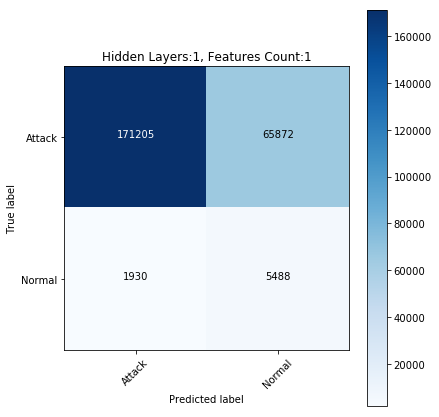

In [20]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [21]:
psg = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
psg.test_score.mean()

no_of_features  hidden_layers
1               1                0.809641
                3                0.764017
8               1                0.711057
                3                0.772862
42              1                0.587086
                3                0.819853
Name: test_score, dtype: float64

In [22]:
past_scores

epoch  f1_score  test_score  time_taken  \
no_of_features hidden_layers                                               
1              1              20150125       NaN    0.792998    6.465645   
               1              20150129       NaN    0.811154   78.618491   
               1              20150128       NaN    0.811669  124.388594   
8              1              20150125       NaN    0.267464    6.469462   
               1              20150101       NaN    0.340111   10.298638   
               1              20150105       NaN    0.442166   23.231877   
               1              20150124       NaN    0.485988  112.785330   
42             1              20150125       NaN    0.153650    6.365872   
               1              20150101       NaN    0.225749   10.108851   
               1              20150105       NaN    0.312944   22.972485   
               1              20150123       NaN    0.314376   76.573661   
1              3              20150125       NaN    0.365286    6.527218   
               3              20150101       NaN    0.423455   10.482187   
               3              20150105       NaN    0.626541   23.440308   
8              3              20150125       NaN    0.863958    6.728304   
               3              20150131       NaN    0.879492   29.744492   
               3              20150127       NaN    0.904895   41.474186   
               3              20150122       NaN    0.913925   57.709625   
               3              20150124       NaN    0.935750  115.324801   
42             3              20150125       NaN    0.892468    7.935754   
               3              20150131       NaN    0.936377   40.383476   
               3              20150128       NaN    0.939672  233.162456   
1              1              20150125       NaN    0.792998    6.465645   
               1              20150129       NaN    0.811154   78.618491   
               1              20150128       NaN    0.811669  124.388594   
8              1              20150125       NaN    0.267464    6.469462   
               1              20150101       NaN    0.340111   10.298638   
               1              20150105       NaN    0.442166   23.231877   
               1              20150124       NaN    0.485988  112.785330   
42             1              20150125       NaN    0.153650    6.365872   
               1              20150101       NaN    0.225749   10.108851   
               1              20150105       NaN    0.312944   22.972485   
               1              20150123       NaN    0.314376   76.573661   
1              3              20150125       NaN    0.365286    6.527218   
               3              20150101       NaN    0.423455   10.482187   
               3              20150105       NaN    0.626541   23.440308   
8              3              20150125       NaN    0.863958    6.728304   
               3              20150131       NaN    0.879492   29.744492   
               3              20150127       NaN    0.904895   41.474186   
               3              20150122       NaN    0.913925   57.709625   
               3              20150124       NaN    0.935750  115.324801   
42             3              20150125       NaN    0.892468    7.935754   
               3              20150131       NaN    0.936377   40.383476   
               3              20150128       NaN    0.939672  233.162456   
1              1              20150125       NaN    0.467957   11.481968   
               1              20150101       NaN    0.556311   18.310476   
               1              20150105       NaN    0.703291   41.359956   
               1              20150102       NaN    0.704369   65.632673   
               1              20150104       NaN    0.828677  125.094539   
8              1              20150125       NaN    0.679324    6.319008   
...                                ...       ...         ...         ...   
     

In [23]:
psg = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
psg.mean().test_score

no_of_features  hidden_layers
1               1                0.809641
                3                0.764017
8               1                0.711057
                3                0.772862
42              1                0.587086
                3                0.819853
Name: test_score, dtype: float64